In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report
import joblib
from imblearn.under_sampling import RandomUnderSampler

# Loading the dataset and a quick inspection

In [3]:
# Load the dataset
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

# Quick inspection
print(df.head())
print("\nClass distribution (isFraud):\n", df["isFraud"].value_counts())
print("\nFraudulent transaction types:\n", df[df["isFraud"] == 1]["type"].value_counts())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  

Class distribution (isFraud):
 isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraudulent t

# Exploratory Data Analysis

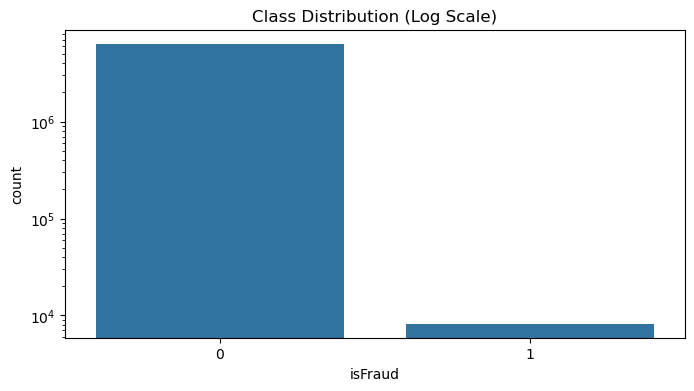

In [5]:
# Plot fraud vs non-fraud (log scale for visibility)
plt.figure(figsize=(8, 4))
ax = sns.countplot(x="isFraud", data=df)
plt.title("Class Distribution (Log Scale)")
ax.set_yscale("log")
plt.show()

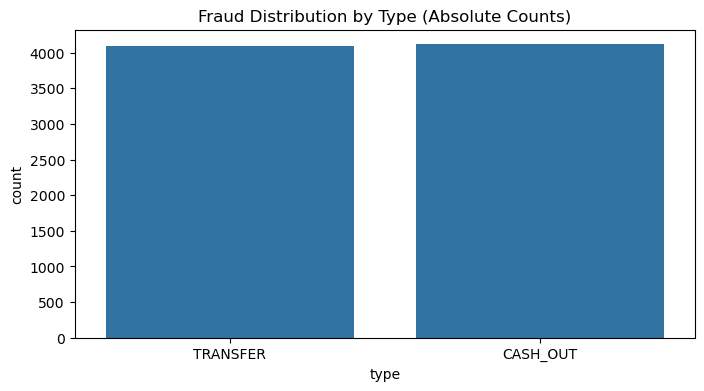

In [6]:
# Plot only fraud transactions (filtered)
plt.figure(figsize=(8, 4))
sns.countplot(x="type", data=df[df["isFraud"] == 1])
plt.title("Fraud Distribution by Type (Absolute Counts)")
plt.show()

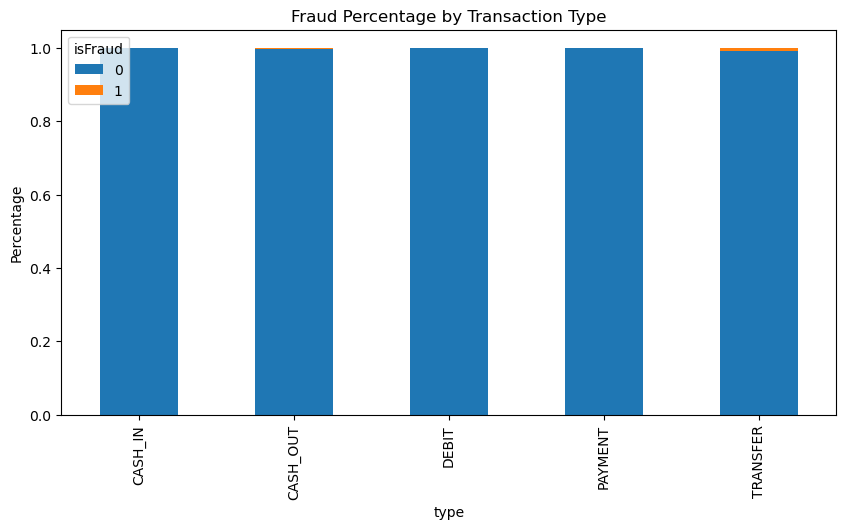

In [7]:
# Normalized stacked bar (percentage)
fraud_by_type = df.groupby("type")["isFraud"].value_counts(normalize=True).unstack()
fraud_by_type.plot(kind="bar", stacked=True, figsize=(10, 5))
plt.title("Fraud Percentage by Transaction Type")
plt.ylabel("Percentage")
plt.show()

# Feature Engineering

In [9]:
# Drop columns not useful for modeling
df = df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

# Convert categorical 'type' to numerical
df["type"] = df["type"].map({"CASH_OUT": 0, "PAYMENT": 1, "CASH_IN": 2, "TRANSFER": 3, "DEBIT": 4})

# Create new features
df["balance_change_orig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balance_change_dest"] = df["oldbalanceDest"] - df["newbalanceDest"]

# Check for NaN/Infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Train-Test split

In [11]:
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# Split data (stratify to maintain class imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Undersample majority class to increase fraud signal
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

print(f"Train shape (after balancing): {X_train.shape}, Test shape: {X_test.shape}")

Train shape (after balancing): (11498, 9), Test shape: (1908786, 9)


# Training a Hybrid Model (XG Boost + Rule-Based)

In [13]:
# Precision Optimized Rules 
def rule_based_filter(df):
    """
    Enhanced rules that don't depend on dropped columns
    Now uses only features available after preprocessing
    """
    return (
        (df["type"] == 3) &                          # Transfer
        (df["amount"] > df["amount"].quantile(0.9995)) &  # Top 0.05%
        (df["oldbalanceOrg"] - df["newbalanceOrig"] == df["amount"]) &  # Complete transfer
        (df["step"] % 24 < 6) &                     # Night hours (12AM-6AM)
        (df["amount"] > 3 * df["amount"].median())   # Alternative velocity check
    )

# Model Training 
fn_cost = 500
fp_cost = 10
review_cost = 2

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    max_depth=5,
    learning_rate=0.1,
    reg_alpha=0.5,
    reg_lambda=0.5,
    early_stopping_rounds=5,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)

# Decision System 
def predict_transaction(X):
    # Ensuring that we are working with a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=X_train.columns)
    
    probas = model.predict_proba(X)[:, 1]
    rule_flags = rule_based_filter(X)
    
    return np.select(
        [
            rule_flags,                            # Certain fraud
            probas >= 0.9,                         # High confidence
            (probas >= 0.7) & (probas < 0.9),      # Medium confidence
            probas < 0.7                           # Legitimate
        ],
        [
            2,  # Confirmed_Fraud
            1,  # High_Risk
            0.5, # Needs_Review
            0   # Legitimate
        ]
    )

# Performance Analysis
def analyze_performance(y_true, X_test):
    # Converting it to DataFrame
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=X_train.columns)
    
    preds = predict_transaction(X_test)
    
    # Calculate metrics
    conf_matrix = confusion_matrix(y_true, np.where(preds == 0.5, 0, preds >= 1))
    tn, fp, fn, tp = conf_matrix.ravel()
    reviews_needed = sum(preds == 0.5)
    
    # Cost calculations
    fraud_savings = tp * fn_cost
    fraud_losses = fn * fn_cost
    fp_costs = fp * fp_cost
    review_costs = reviews_needed * review_cost
    
    print("=== TIERED DECISION DISTRIBUTION ===")
    print(f"Confirmed Fraud (Auto-Block): {sum(preds == 2):,}")
    print(f"High Risk (Auto-Block + Review): {sum(preds == 1):,}")
    print(f"Needs Manual Review: {reviews_needed:,}")
    print(f"Legitimate: {sum(preds == 0):,}")
    
    print("\n=== FINANCIAL IMPACT ===")
    print(f"Fraud Prevention Value: ${fraud_savings:,}")
    print(f"Potential Fraud Losses: ${fraud_losses:,}")
    print(f"False Alarm Costs: ${fp_costs:,}")
    print(f"Review Costs: ${review_costs:,}")
    print(f"NET SAVINGS: ${fraud_savings - fraud_losses - fp_costs - review_costs:,}")

# Production API
class FraudDetectionEngine:
    def __init__(self, model_path=None):
        if model_path:
            self.model = joblib.load(model_path)
        else:
            self.model = model
            
    def predict(self, transaction):
        # Ensure DataFrame with correct columns
        if not isinstance(transaction, pd.DataFrame):
            transaction = pd.DataFrame([transaction], columns=X_train.columns)
        
        proba = float(self.model.predict_proba(transaction)[0][1])
        
        if rule_based_filter(transaction).iloc[0]:
            return {
                "decision": "CONFIRMED_FRAUD",
                "probability": proba,
                "action": "block_and_alert"
            }
        elif proba >= 0.9:
            return {
                "decision": "HIGH_RISK",
                "probability": proba,
                "action": "block_with_review"
            }
        elif proba >= 0.7:
            return {
                "decision": "NEEDS_REVIEW", 
                "probability": proba,
                "action": "hold_for_manual"
            }
        else:
            return {
                "decision": "LEGITIMATE",
                "probability": proba,
                "action": "allow"
            }

# Test the system
try:
    analyze_performance(y_test, X_test)
    print("\nSystem test completed successfully!")
except Exception as e:
    print(f"\nError during testing: {str(e)}")

[0]	validation_0-aucpr:0.17118
[10]	validation_0-aucpr:0.31000
[20]	validation_0-aucpr:0.33339
[30]	validation_0-aucpr:0.35369
[40]	validation_0-aucpr:0.76968
[50]	validation_0-aucpr:0.80948
[60]	validation_0-aucpr:0.83946
[70]	validation_0-aucpr:0.86238
[80]	validation_0-aucpr:0.87031
[90]	validation_0-aucpr:0.87637
[99]	validation_0-aucpr:0.88230
=== TIERED DECISION DISTRIBUTION ===
Confirmed Fraud (Auto-Block): 0
High Risk (Auto-Block + Review): 8,906
Needs Manual Review: 8,887
Legitimate: 1,890,993

=== FINANCIAL IMPACT ===
Fraud Prevention Value: $1,189,500
Potential Fraud Losses: $42,500
False Alarm Costs: $65,270
Review Costs: $17,774
NET SAVINGS: $1,063,956

System test completed successfully!


In [14]:
# Optimized Fraud Detection System - Essential Metrics 

def analyze_performance(y_true, X_test):
    # Convert to DataFrame
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=X_train.columns)
    
    # Getting predictions
    preds = predict_transaction(X_test)
    probas = model.predict_proba(X_test)[:, 1]
    
    # Converting tiered predictions to binary (consider REVIEW as 0)
    binary_preds = np.where(preds == 0.5, 0, preds >= 1)
    
    # Core Metrics Calculation
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT:")
    print(classification_report(y_true, binary_preds, digits=4))
    
    print("\n" + "="*50)
    print("CONFUSION MATRIX:")
    tn, fp, fn, tp = confusion_matrix(y_true, binary_preds).ravel()
    print(f"""
    True Positives (TP): {tp}
    False Positives (FP): {fp}
    True Negatives (TN): {tn}
    False Negatives (FN): {fn}
    """)
    
    print("="*50)
    print("KEY METRICS:")
    print(f"Precision: {precision_score(y_true, binary_preds):.4f}")
    print(f"Recall/Sensitivity: {recall_score(y_true, binary_preds):.4f}")
    print(f"F1-Score: {f1_score(y_true, binary_preds):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, probas):.4f}")
    print(f"Average Precision: {average_precision_score(y_true, probas):.4f}")
    
    # Tiered Decision Analysis
    reviews_needed = sum(preds == 0.5)
    
    print("\n" + "="*50)
    print("TIERED DECISION DISTRIBUTION:")
    print(f"Confirmed Fraud (Auto-Block): {sum(preds == 2):,}")
    print(f"High Risk (Auto-Block + Review): {sum(preds == 1):,}")
    print(f"Needs Manual Review: {reviews_needed:,}")
    print(f"Legitimate: {sum(preds == 0):,}")
    
    # Financial Impact Analysis
    fraud_savings = tp * fn_cost
    fraud_losses = fn * fn_cost
    fp_costs = fp * fp_cost
    review_costs = reviews_needed * review_cost
    
    print("\n" + "="*50)
    print("FINANCIAL IMPACT:")
    print(f"Fraud Prevention Value: ${fraud_savings:,}")
    print(f"Potential Fraud Losses: ${fraud_losses:,}")
    print(f"False Alarm Costs: ${fp_costs:,}")
    print(f"Review Costs: ${review_costs:,}")
    print(f"NET SAVINGS: ${fraud_savings - fraud_losses - fp_costs - review_costs:,}")

# Run the optimized analysis
analyze_performance(y_test, X_test)


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0     1.0000    0.9966    0.9983   1906322
           1     0.2671    0.9655    0.4185      2464

    accuracy                         0.9965   1908786
   macro avg     0.6335    0.9810    0.7084   1908786
weighted avg     0.9990    0.9965    0.9975   1908786


CONFUSION MATRIX:

    True Positives (TP): 2379
    False Positives (FP): 6527
    True Negatives (TN): 1899795
    False Negatives (FN): 85
    
KEY METRICS:
Precision: 0.2671
Recall/Sensitivity: 0.9655
F1-Score: 0.4185
ROC AUC: 0.9995
Average Precision: 0.8822

TIERED DECISION DISTRIBUTION:
Confirmed Fraud (Auto-Block): 0
High Risk (Auto-Block + Review): 8,906
Needs Manual Review: 8,887
Legitimate: 1,890,993

FINANCIAL IMPACT:
Fraud Prevention Value: $1,189,500
Potential Fraud Losses: $42,500
False Alarm Costs: $65,270
Review Costs: $17,774
NET SAVINGS: $1,063,956


# Saving the model

In [16]:
# Save XGBoost model as JSON (portable, booster-safe)
joblib.dump(model, "fraud_model.pkl")  # model must be XGBClassifier, not booster
model.save_model("fraud_model.json")
print("Saved model as fraud_model.json")

# Save preprocessing info as before
joblib.dump({
    "feature_names": X_train.columns.tolist(),
    "type_mapping": {"CASH_OUT": 0, "PAYMENT": 1, "CASH_IN": 2, "TRANSFER": 3, "DEBIT": 4}
}, "preprocess_info.pkl")
print("Saved preprocess_info.pkl")

Saved model as fraud_model.json
Saved preprocess_info.pkl
